## 1. Pronosticador de la demanda

Para la implementación del modelo más confiable que se adapate a los datos se exploraron 2 modelos principales de regresiones. Por una parte en la sección  1.1 se presenta el modelo ARIMA con la configuración de parámetros más optimas que se encontró para el seguimiento del comportamiento de la demanda según los datos de entrenamiento. Por otra parte, en la sección 1.2 se diseño un modelo XGBoost de regresión para ver cómo respondía a los datos de entrenamiento. Se utilizó para éste caracteristicas agregadas para la entrada del modelo y se encontraron mejores resultados. Lo anterior según las métricas de evaluación MSE, RMSE, R2, MAE y MAPE. 

Para el entrenamiento y ajuste de los modelos y su evaluación, se dividió el dataset en 85% para datos de entrenamiento y 15% para datos de validación. 

Finalmente en la sección 1.3 se realiza el almacenamiento en un archivo de los datos pronosticados en conjunto con los datos iniciales del dataset, como es requerido en el problema. El archivo de salida con los datos lleva el nombre de output_dataset_demand_acumulate.csv

Como conclusión se elige el modelo XGBoost para la regresión en el pronóstico de la demanda, ya que presenta mejor desempeño en los datos de validación.

### 1.1 Modelo ARIMA

In [ ]:
!pip install pandas statsmodels matplotlib

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood op

Validation MSE: 62080.91
Validation RMSE: 249.16
Validation R²: 0.92
Validation MAE: 212.13
Validation MAPE: 30.14%


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood o

2022-05-01    1192.506869
2022-06-01    1270.836663
2022-07-01    1382.840247
Freq: MS, Name: predicted_mean, dtype: float64


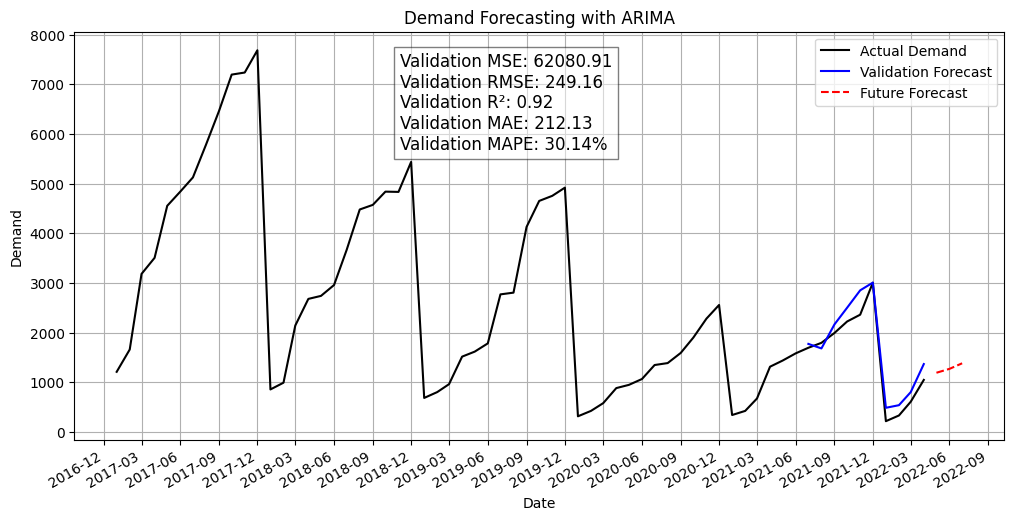

In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Cargar el archivo CSV
df = pd.read_csv('../data/dataset_demand_acumulate.csv')

# Convertir la columna 'year_month' a tipo datetime y establecerla como índice
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')
df.set_index('year_month', inplace=True)

# Mostrar las primeras filas del dataframe
df.head()

# Definir el tamaño de cada conjunto
train_size = int(len(df) * 0.85)
validation_size = len(df) - train_size

# Dividir los datos
train = df.iloc[:train_size]
validation = df.iloc[train_size:]

# Crear el modelo ARIMA
model = sm.tsa.ARIMA(train, order=(8, 0, 1), seasonal_order=(2, 0, 1, 12))
model_fit = model.fit()

# Realizar predicciones en el conjunto de validación
validation_forecast = model_fit.forecast(steps=validation_size)

# Crear el DataFrame de predicciones usando el índice del conjunto de validación
validation_forecast_df = pd.DataFrame(validation_forecast, index=validation.index, columns=['Predicted'])

# Calcular las métricas de evaluación en el conjunto de validación
mse_validation = mean_squared_error(validation['Demand'], validation_forecast)
rmse_validation = mse_validation**0.5
r2_validation = r2_score(validation['Demand'], validation_forecast)
mae_validation = mean_absolute_error(validation['Demand'], validation_forecast)
mape_validation = (abs((validation['Demand'] - validation_forecast) / validation['Demand'])).mean() * 100

print(f'Validation MSE: {mse_validation:.2f}')
print(f'Validation RMSE: {rmse_validation:.2f}')
print(f'Validation R²: {r2_validation:.2f}')
print(f'Validation MAE: {mae_validation:.2f}')
print(f'Validation MAPE: {mape_validation:.2f}%')

# Reentrenar el modelo con todos los datos
model_all = sm.tsa.ARIMA(df, order=(8, 0, 1), seasonal_order=(2, 0, 1, 12))
model_all_fit = model_all.fit()

# Realizar predicciones en el dataset completo
all_forecast = model_all_fit.fittedvalues
all_forecast_df = pd.DataFrame(all_forecast, index=df.index, columns=['Predicted'])

# Realizar predicciones para los próximos 3 meses
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=3, freq='MS')
future_forecast = model_all_fit.forecast(steps=3)
future_forecast_df = pd.DataFrame(future_forecast, index=future_dates, columns=['Predicted'])
print(future_forecast)

# Visualización de los Resultados
plt.figure(figsize=(12, 6))

# Plotear datos originales
plt.plot(df.index, df['Demand'], label='Actual Demand', color='black')

# Plotear pronósticos de validación
plt.plot(validation.index, validation_forecast, label='Validation Forecast', color='blue')

# Plotear pronósticos futuros
plt.plot(future_forecast_df.index, future_forecast, label='Future Forecast', color='red', linestyle='--')

# Añadir las métricas de evaluación en un recuadro
metrics_text = (f'Validation MSE: {mse_validation:.2f}\nValidation RMSE: {rmse_validation:.2f}\n'
                f'Validation R²: {r2_validation:.2f}\nValidation MAE: {mae_validation:.2f}\n'
                f'Validation MAPE: {mape_validation:.2f}%')
plt.gca().text(0.35, 0.95, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.title('Demand Forecasting with ARIMA')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.grid(True)

# Formatear el eje X para mostrar etiquetas mensuales
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Intervalo de 3 meses
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotar las etiquetas del eje X para mejor visualización
plt.gcf().autofmt_xdate()

plt.show()


### 1.2 Modelo XGBoost Regressor

In [ ]:
!pip install xgboost

c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:12:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:12:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


Validation MSE: 37958.08
Validation RMSE: 194.83
Validation R²: 0.96
Validation MAE: 152.59
Validation MAPE: 11.61%
              Predicted
2022-05-01  1313.550903
2022-06-01  1286.439087
2022-07-01  1734.572021


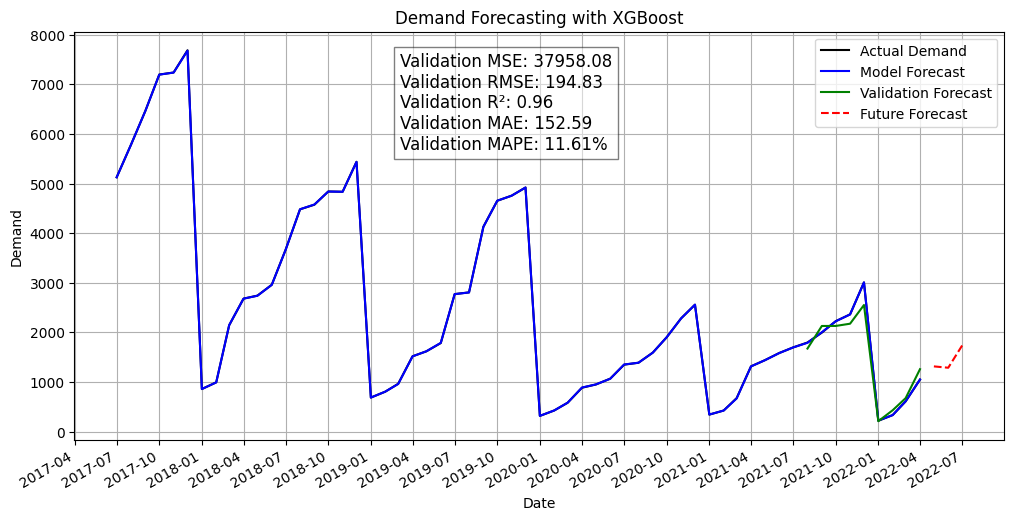

In [2]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Cargar el archivo CSV
df = pd.read_csv('../data/dataset_demand_acumulate.csv')

# Convertir la columna 'year_month' a tipo datetime y establecerla como índice
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')
df.set_index('year_month', inplace=True)

# Crear características adicionales
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Lag1'] = df['Demand'].shift(1)
df['Lag2'] = df['Demand'].shift(2)
df['Lag3'] = df['Demand'].shift(3)
df['Lag4'] = df['Demand'].shift(4)
df['Lag5'] = df['Demand'].shift(5)
df['Lag6'] = df['Demand'].shift(6)
df['Diff1'] = df['Demand'].diff(1)
df['Diff2'] = df['Demand'].diff(2)

# Eliminar valores nulos
df.dropna(inplace=True)

# Separar características y objetivo
X = df[['Month', 'Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Lag6', 'Diff1', 'Diff2']]
y = df['Demand']

# Dividir los datos en entrenamiento y validación
train_size = int(len(df) * 0.85)
train = df.iloc[:train_size]
validation = df.iloc[train_size:]

# Separar características y objetivo para entrenamiento y validación
X_train = train[['Month', 'Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Lag6', 'Diff1', 'Diff2']]
y_train = train['Demand']
X_valid = validation[['Month', 'Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Lag6', 'Diff1', 'Diff2']]
y_valid = validation['Demand']

# Crear y entrenar el modelo XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=120, max_depth=5, learning_rate=0.1, alpha=0.1, lambda_=0.1)
model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de validación
validation_forecast = model.predict(X_valid)

# Crear el DataFrame de predicciones usando el índice del conjunto de validación
validation_forecast_df = pd.DataFrame(validation_forecast, index=validation.index, columns=['Predicted'])

# Calcular las métricas de evaluación en el conjunto de validación
mse_validation = mean_squared_error(y_valid, validation_forecast)
rmse_validation = mse_validation**0.5
r2_validation = r2_score(y_valid, validation_forecast)
mae_validation = mean_absolute_error(y_valid, validation_forecast)
mape_validation = (abs((y_valid - validation_forecast) / y_valid)).mean() * 100

print(f'Validation MSE: {mse_validation:.2f}')
print(f'Validation RMSE: {rmse_validation:.2f}')
print(f'Validation R²: {r2_validation:.2f}')
print(f'Validation MAE: {mae_validation:.2f}')
print(f'Validation MAPE: {mape_validation:.2f}%')

# Reentrenar el modelo con todos los datos
model_all = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=120, max_depth=5, learning_rate=0.1, alpha=0.1, lambda_=0.1)
model_all.fit(X, y)

# Realizar predicciones en el dataset completo
all_forecast = model_all.predict(X)
all_forecast_df = pd.DataFrame(all_forecast, index=df.index, columns=['Predicted'])

# Realizar predicciones para los próximos 3 meses
future_dates = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=3, freq='MS')
X_future = pd.DataFrame({
    'Month': future_dates.month,
    'Year': future_dates.year,
    'Lag1': [df['Demand'].iloc[-1]] * 3,  # Suponiendo que el último valor es la base para los lags
    'Lag2': [df['Demand'].iloc[-2]] * 3 if len(df) > 1 else [df['Demand'].iloc[-1]] * 3,
    'Lag3': [df['Demand'].iloc[-3]] * 3 if len(df) > 2 else [df['Demand'].iloc[-1]] * 3,
    'Lag4': [df['Demand'].iloc[-4]] * 3 if len(df) > 3 else [df['Demand'].iloc[-1]] * 3,
    'Lag5': [df['Demand'].iloc[-5]] * 3 if len(df) > 4 else [df['Demand'].iloc[-1]] * 3,
    'Lag6': [df['Demand'].iloc[-6]] * 3 if len(df) > 5 else [df['Demand'].iloc[-1]] * 3,
    'Diff1': [df['Demand'].diff(1).iloc[-1]] * 3,
    'Diff2': [df['Demand'].diff(2).iloc[-1]] * 3
})
future_forecast = model_all.predict(X_future)
future_forecast_df = pd.DataFrame(future_forecast, index=future_dates, columns=['Predicted'])
print(future_forecast_df)

# Visualización de los Resultados
plt.figure(figsize=(12, 6))


plt.plot(df.index, df['Demand'], label='Actual Demand', color='black')
plt.plot(all_forecast_df.index, all_forecast, label='Model Forecast', color='blue')
plt.plot(validation.index, validation_forecast, label='Validation Forecast', color='green')
plt.plot(future_forecast_df.index, future_forecast, label='Future Forecast', color='red', linestyle='--')

# Añadir las métricas de evaluación en un recuadro
metrics_text = (f'Validation MSE: {mse_validation:.2f}\nValidation RMSE: {rmse_validation:.2f}\n'
                f'Validation R²: {r2_validation:.2f}\nValidation MAE: {mae_validation:.2f}\n'
                f'Validation MAPE: {mape_validation:.2f}%')
plt.gca().text(0.35, 0.95, metrics_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

plt.title('Demand Forecasting with XGBoost')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.grid(True)

# Formatear el eje X para mostrar etiquetas mensuales
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Intervalo de 1 mes
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotar las etiquetas del eje X para mejor visualización
plt.gcf().autofmt_xdate()

plt.show()


### 1.3 Ecritura y Almacenamiento Archivo con Pronósticos de Salida

In [4]:
# Crear un DataFrame con las fechas futuras y las predicciones
df_existing = pd.read_csv('../data/dataset_demand_acumulate.csv')

# Convertir el índice del DataFrame a una columna
future_forecast_df['year_month'] = future_forecast_df.index.strftime('%Y-%m')

# Renombrar la columna de predicciones a 'Demand' para coincidir con el formato del archivo original
future_forecast_df.rename(columns={'Predicted': 'Demand'}, inplace=True)

# Concatenar el DataFrame existente con el DataFrame de predicciones
df_final = pd.concat([df_existing, future_forecast_df[['year_month', 'Demand']]], ignore_index=True)

# Guardar el DataFrame final en un nuevo archivo CSV
output_path = 'output/output_dataset_demand_acumulate.csv'
df_final.to_csv(output_path, index=False)